# Animal pose dataset preparation for ControlNet training with OpenPifPaf and Hugging Face

_By: MediaPipe team (Google), Diffusers team (Hugging Face), John Fozard (jfozard), Fiacre Rougieux (fi4cr)

This notebook provides an end-to-end example of preparing a dataset that is compatible with [ControlNet training](https://github.com/huggingface/diffusers/tree/main/examples/controlnet) using OpenPifPaf and Hugging Face. Specifically, in this notebook, we

* Load animals from [Laion5B](https://laion.ai/blog/laion-5b/) using caption base filtering.
* Prepare conditioning images from the original images of the dataset using [OpenPifPaf](https://github.com/openpifpaf/openpifpaf) which has an [animal pose model](https://openpifpaf.github.io/plugins_animalpose.html)
* Prepare the final dataset using [🤗 Datasets](https://huggingface.co/docs/datasets) and push it to the Hugging Face Hub. 

Let's get started!

## Install libraries

In [30]:
!pip install -q datasets transformers accelerate openpifpaf matplotlib opencv-python-headless tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
img2dataset 1.41.0 requires pyarrow<8,>=6.0.1, but you have pyarrow 11.0.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import tensorflow as tf
## Need to stop tf allocating all of the GPU memory - probably shouldn't mix pt and tf like this.
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-04-26 10:14:59.177464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 10:15:01.253276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
IMG_SIZE = 512

def crop_center(image):
    print(image.shape)
    h, w = image.shape[-3], image.shape[-2]
    if h > w:
        cropped_image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        cropped_image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
    return tf.image.resize_images(cropped_image, (IMG_SIZE, IMG_SIZE))

def preprocess_image(example):
    # extract the image and label from the example
    image = example['image']
    label = example["objects"]['label']
    
    shape = tf.shape(image)
    height = shape[0]
    width = shape[1]
    
    crop_size = tf.minimum(height, width)
    crop_offset_height = (height - crop_size) // 2
    crop_offset_width = (width - crop_size) // 2
    image = tf.image.crop_to_bounding_box(image, crop_offset_height, crop_offset_width, crop_size, crop_size)

    # resize the image to the desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    

    # normalize the image
    image = tf.cast(image, tf.uint8)

    return {'image': image, 'label': label}

In [4]:
import openpifpaf
openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 100
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30-animalpose')
predictor.long_edge = 512
predictor.preprocess = predictor._preprocess_factory()

In [5]:
meta = openpifpaf.plugins.animalpose.animal_kp.AnimalKp().head_metas[0]

The connections listed in the OpenPifaf metadata are for a 1-based array
 but in python we prefer zero-based, so subtract 1 from them

In [6]:
zero_based_skeleton = [ (a-1, b-1) for a,b in meta.draw_skeleton] 

In [7]:
# Adapted MediaPipe Pose annotation for ControlNet.
# There are fewer keypoints (20) and different connections
# for animals compared to humans

from typing import Any
import numpy as np
import math
import cv2

# Body joint color map. #BGR
_JOINT_CMAP = {
    0: [0, 0, 255],
    1: [255, 208, 0],
    2: [255, 161, 0],
    3: [255, 114, 0],
    4: [0, 189, 255],
    5: [0, 236, 255],
    6: [0, 255, 226],
    7: [255, 0, 76],
    8: [0, 255, 131],
    9: [255, 0, 171],
    10: [0, 255, 37],
    11: [244, 0, 253],
    12: [57, 255, 0],
    13: [151, 0, 255],
    14: [151, 255, 0],
    15: [57, 0, 255],
    16: [245, 255, 0],
    17: [0, 39, 255],
    18: [255, 169, 0],
    19: [0, 133, 255],
}


# Connection color map. #BGR
# These colors probably matter a little, and it's not clear
# exactly how to choose them
# For instance - should they be similar to the keypoint colours or not?
# I've just taken them from the example notebook

_CONNECTION_CMAP = {
 (0, 1): [127, 104, 127],
 (0, 2): [0, 94, 255],
 (0, 5): [255, 184, 0],
 (1, 3): [255, 137, 0],
 (2, 4): [255, 57, 38],
 (1, 2): [0, 212, 255],
 (5, 7): [0, 245, 240],
 (5, 8): [0, 255, 178],
 (5, 9): [127, 127, 104],
 (6, 7): [150, 127, 126],
 (6, 10): [197, 0, 254],
 (6, 11): [122, 127, 221],
 (9, 13): [104, 255, 0],
 (13, 17): [156, 127, 56],
 (8, 12): [104, 0, 255],
 (12, 16): [198, 255, 0],
 (11, 15): [28, 19, 255],
 (15, 19): [28, 66, 255],
 (10, 14): [28, 114, 255],
 (14, 18): [250, 212, 0],
}

# The connections liste


In [8]:
def draw_pose(
    image: np.ndarray,
    landmark_list: Any,
    connections: Any,
    overlay: bool = True,
) -> tuple[np.ndarray, dict[str, list[float]]]:
    """Draws the landmarks and the connections on the image.

    Args:
      image: A three channel BGR image represented as numpy ndarray.
      landmark_list: A normalized landmark list proto message to be annotated on
        the image.
      connections: A list of landmark index tuples that specifies how landmarks to
        be connected in the drawing.
      overlay: Whether to overlay on the input image.

    Returns:
      (image, dictionary).

    Raises:
      ValueError: If one of the following:
        a) If the input image is not three channel BGR.
        b) If any connetions contain invalid landmark index.
    """
    if image.shape[2] != 3:
        raise ValueError("Input image must contain three channel bgr data.")
    image_rows, image_cols, _ = image.shape
    min_length = min(image_rows, image_cols)
    draw_line_width = math.floor(min_length * 0.01)
    draw_circle_radius = math.floor(min_length * 0.015)
    idx_to_coordinates = {}
    
    for idx, landmark in enumerate(landmark_list):
        if landmark[2]>0.0:
            idx_to_coordinates[idx] = (int(landmark[0]), int(landmark[1]))
            
    if overlay:
        output_image = image.copy()
    else:
        output_image = np.zeros(
            list(image.shape[:2])
            + [
                3,
            ],
            dtype=np.uint8,
        )

    if connections:
        num_landmarks = len(landmark_list)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    "Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                cv2.line(
                    output_image,
                    pt1=idx_to_coordinates[start_idx],
                    pt2=idx_to_coordinates[end_idx],
                    color=_CONNECTION_CMAP[(start_idx, end_idx)],
                    thickness=draw_line_width,
                )

    # Draws landmark points after finishing the connection lines, which is
    # aesthetically better.
    for idx, landmark_px in idx_to_coordinates.items():
        # Fill color into the circle
        cv2.circle(
            output_image,
            center=landmark_px,
            radius=draw_circle_radius,
            color=_JOINT_CMAP[idx],
            thickness=-1,
        )

    return output_image

In [9]:
import torch
torch.cuda.empty_cache()

def determine_pose(image):
    """Estimates pose and creates an image with just the pose body points.

    The image consisting the pose body points serves as the conditioning image
    for ControlNet training.

    Args:
        image: A three channel RGB image represented as a tf.Tensor.

    Returns:
        A tuple consisting of the original image (`image`), an image where
        the original image is overlaid with the pose keypoints, and an image
        with just the pose keypoints.
    """
    image = np.asarray(image)
    
    predictions, gt_anns, image_meta = predictor.numpy_image(image)
    if not predictions:
        data = np.zeros((20,3))
    else:
        data = predictions[0].data

    # Draw pose landmarks on a copy of the input image.
    annotated_image = draw_pose(
        image, data, zero_based_skeleton
    )

        # Draw pose landmarks on a blank image.
    blank_image = draw_pose(
        image, data, zero_based_skeleton, False
    )

    return image, annotated_image, blank_image

In [10]:
def crop_image(img):
    # Get the dimensions of the original image
    width, height = img.size

    # Find the coordinates of the center of the image
    center_x = width / 2
    center_y = height / 2

    # Find the coordinates of the upper left and lower right corners of the crop box
    crop_left = center_x - 256
    crop_top = center_y - 256
    crop_right = center_x + 256
    crop_bottom = center_y + 256

    # Crop the image to the specified dimensions
    cropped_image = img.crop((crop_left, crop_top, crop_right, crop_bottom))

    # Resize the cropped image to 512x512
    resized_image = cropped_image.resize((512, 512))

    return resized_image

In [11]:
import requests
from PIL import Image
from io import BytesIO
import json
import matplotlib.pyplot as plt

def resize_image(input_image):
    input_image = np.asarray(input_image)
    height, width, C = input_image.shape
    if height < width:
        scale = 512 / height
    else:
        scale = 512 / width
    new_height = int(height * scale)
    new_width = int(width * scale)
    img = cv2.resize(input_image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4 if scale > 1 else cv2.INTER_AREA)
    img = img[:512, :512, :]
    img = Image.fromarray(img)
    return img



In [12]:
with open('urls.json', 'r') as f:
    my_dict = json.load(f)

captions_list = list(my_dict.keys())
urls_list = list(my_dict.values())

response = requests.get(urls_list[10])
img = resize_image(Image.open(BytesIO(response.content)))

with open('myimglist.txt', 'w') as f:
    for value in my_dict.values():
        f.write('"'+value+'"' + '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'urls.json'

In [13]:
!pip install img2dataset

  Using cached pyarrow-7.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.11.0 requires pyarrow>=8.0.0, but you have pyarrow 7.0.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [14]:
!mkdir output_folder

mkdir: cannot create directory ‘output_folder’: File exists


In [15]:
!img2dataset --url_list=myimglist.txt --output_folder=output_folder --thread_count=64 --image_size=512

Starting the downloading of this file
Sharding file number 1 of 1 called /workspace/myimglist.txt
0it [00:00, ?it/s]File sharded in 0 shards
0it [00:00, ?it/s]


In [16]:
import os

jpg_files = []
folder = 'output_folder/00000/'
for file_name in os.listdir(folder):
    if file_name.endswith('.jpg'):
        jpg_files.append(folder+file_name)

jpg_files

['output_folder/00000/000000018.jpg',
 'output_folder/00000/000000021.jpg',
 'output_folder/00000/000000019.jpg',
 'output_folder/00000/000000023.jpg',
 'output_folder/00000/000000012.jpg',
 'output_folder/00000/000000013.jpg',
 'output_folder/00000/000000037.jpg',
 'output_folder/00000/000000049.jpg',
 'output_folder/00000/000000048.jpg',
 'output_folder/00000/000000054.jpg',
 'output_folder/00000/000000052.jpg',
 'output_folder/00000/000000002.jpg',
 'output_folder/00000/000000042.jpg',
 'output_folder/00000/000000008.jpg',
 'output_folder/00000/000000046.jpg',
 'output_folder/00000/000000068.jpg',
 'output_folder/00000/000000061.jpg',
 'output_folder/00000/000000016.jpg',
 'output_folder/00000/000000000.jpg',
 'output_folder/00000/000000063.jpg',
 'output_folder/00000/000000065.jpg',
 'output_folder/00000/000000069.jpg',
 'output_folder/00000/000000057.jpg',
 'output_folder/00000/000000082.jpg',
 'output_folder/00000/000000004.jpg',
 'output_folder/00000/000000040.jpg',
 'output_fol

In [17]:
len(jpg_files)

9401

src/openpifpaf/csrc/src/cif_hr.cpp:102: UserInfo: resizing cifhr buffer
src/openpifpaf/csrc/src/occupancy.cpp:53: UserInfo: resizing occupancy buffer


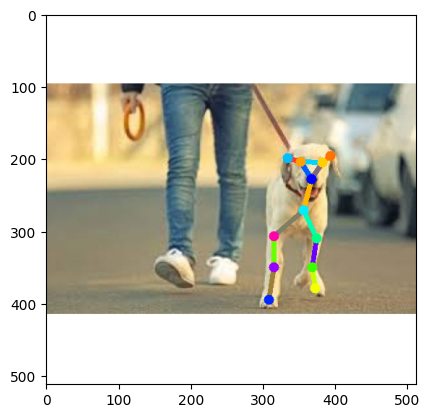

In [18]:
# Test determine_pose on a single image
img = resize_image(Image.open(jpg_files[0]))
output_image, annotated_image, black_image = determine_pose(img)
plt.imshow(annotated_image)

In [19]:
img = resize_image(Image.open(jpg_files[0]))
sample = determine_pose(img)
original_image = sample[0]
annotated_image, blank_image = sample[1], sample[2]



samples = [original_image, annotated_image, blank_image]
titles = ["Input", "Annotation Overlaid", "Annotation"]

## Visualize

Issues making that request


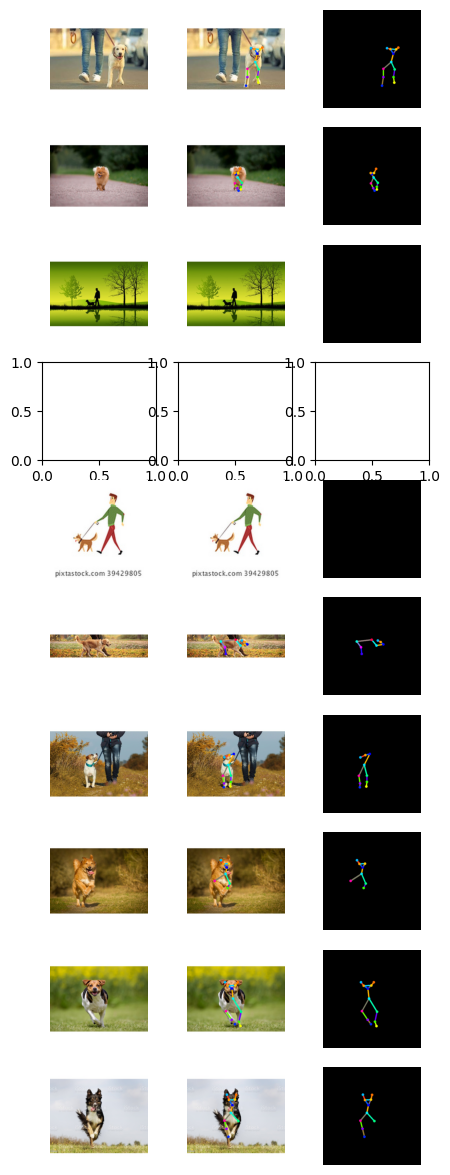

In [20]:
num_samples_to_vis = 10

fig, ax = plt.subplots(ncols=3, nrows=num_samples_to_vis, figsize=(5, 15))
for i in np.arange(num_samples_to_vis):
    
    try:
        img = resize_image(Image.open(jpg_files[i]))
        sample = determine_pose(img)
        original_image = sample[0]
        annotated_image, blank_image = sample[1], sample[2]

        
        
        samples = [original_image, annotated_image, blank_image]
        titles = ["Input", "Annotation Overlaid", "Annotation"]

        for j in range(3):
            ax[i, j].imshow(samples[j])
            ax[i, j].axis("off")
    except:
          print("Issues making that request")

In [21]:
import os
import hashlib
import PIL

## Caption generation with BLIP-2

For this section, we leverage an open-source and powerful pre-trained model for caption generation - [BLIP-2](https://huggingface.co/papers/2301.12597). This model comes with [different checkpoints](https://huggingface.co/models?other=blip-2), among which we're using [Salesforce/blip2-flan-t5-xl](https://huggingface.co/Salesforce/blip2-flan-t5-xl). 

🤗 Transformers also supports its predecessor - [BLIP](https://huggingface.co/papers/2201.12086). 

In the cell below, we first load the following classes: `Blip2Processor` and `Blip2ForConditionalGeneration`. Then we write a utility to generate captions for a given batch of images. 


In [22]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
import numpy as np


torch.cuda.empty_cache()


device = "cuda" if torch.cuda.is_available() else "cpu"
print('torch device', device)

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
captioning_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-flan-t5-xl", torch_dtype=torch.float16
)
captioning_model = captioning_model.to(device)


def generate_captions(images: np.ndarray) -> list[str]:
    """Generates captions for a batch of images.

    Args:
        images: A batch of images in the RGB format.

    Returns:
        A list of generated captions.
    """
    inputs = processor(images=images, return_tensors="pt").to(device, torch.float16)

    generated_ids = captioning_model.generate(**inputs)
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
    generated_texts = [text.strip() for text in generated_texts]
    return generated_texts

torch device cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['a person walking a dog on a leash']
['pomeranian - sassy - sass']
['silhouette of a man walking his dog in the green grass']
Issues making that request
['man walking his dog on a leash']
['a woman walking her dog in the park']
['a man walking his dog in the field']
['a dog running in a field with grass']
['a dog running in the grass with yellow flowers']
['a dog running in a field stock photo']


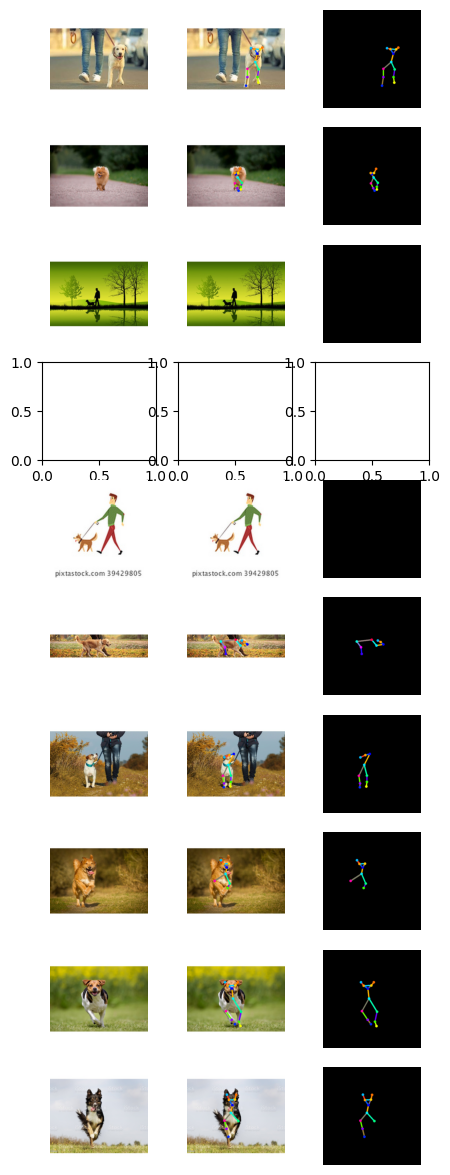

In [23]:
num_samples_to_vis = 10

fig, ax = plt.subplots(ncols=3, nrows=num_samples_to_vis, figsize=(5, 15))
for i in np.arange(num_samples_to_vis):
    
    try:
        img = resize_image(Image.open(jpg_files[i]))
        sample = determine_pose(img)
        original_image = sample[0]
        annotated_image, blank_image = sample[1], sample[2]
        generated_captions = generate_captions(img)
        print(generated_captions)
        
        
        samples = [original_image, annotated_image, blank_image]
        titles = ["Input", "Annotation Overlaid", "Annotation"]

        for j in range(3):
            ax[i, j].imshow(samples[j])
            ax[i, j].axis("off")
    except:
          print("Issues making that request")

## Serialize dataset

In this section, we serialize the original images, their corresponding conditioning images, and generate BLIP captions.

In [28]:
import tqdm
import time

batch_size = 1
data_root = "data"
#new_dataset = dataset.batch(batch_size, drop_remainder=True)

os.makedirs(data_root, exist_ok=True)


def save_image(
    original_image: np.ndarray,
    overlaid_annotation: np.ndarray,
    blank_annotation: np.ndarray,
):
    """Serializes images to `data_root`."""
    image_hash = hashlib.sha1(original_image.tobytes()).hexdigest()
    PIL.Image.fromarray(original_image).save(
        os.path.join(data_root, f"{str(image_hash)}_original.png")
    )
    PIL.Image.fromarray(overlaid_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
    )
    PIL.Image.fromarray(blank_annotation).save(
        os.path.join(data_root, f"{str(image_hash)}_condition.png")
    )
    return image_hash


original_image_paths = []
overlaid_annotation_paths = []
blank_annotation_paths = []
all_generated_captions = []
total = 0

for i in np.arange(len(jpg_files)):
    try:
        img = resize_image(Image.open(jpg_files[i]))
        samples = determine_pose(img)
        generated_captions = generate_captions(img)
        original_images = samples[0]
        overlaid_annotations = samples[1]
        blank_annotations = samples[2]




        image_hash = save_image(
            original_images, overlaid_annotations, blank_annotations
        )
        original_image_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_original.png")
        )
        overlaid_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_overlaid.png")
        )
        blank_annotation_paths.append(
            os.path.join(data_root, f"{str(image_hash)}_condition.png")
        )

        all_generated_captions.append(generated_captions)

        total += 1
        print(str(i/len(jpg_files)*100)+"%")
    except:
        print("Issue")
        print(str(i/len(jpg_files)*100)+"%")

print(f"{total} samples will go in the final dataset.")

0.0%
0.010637166258908625%
0.02127433251781725%
Issue
0.03191149877672588%
0.0425486650356345%
0.053185831294543136%
0.06382299755345176%
0.07446016381236038%
0.085097330071269%
0.09573449633017764%
0.10637166258908627%
0.1170088288479949%
0.12764599510690353%
0.13828316136581215%
0.14892032762472077%
0.15955749388362941%
0.170194660142538%
0.18083182640144665%
0.19146899266035527%
0.2021061589192639%
0.21274332517817254%
0.22338049143708116%
0.2340176576959898%
0.2446548239548984%
0.25529199021380705%
0.2659291564727157%
0.2765663227316243%
0.28720348899053294%
0.29784065524944153%
0.3084778215083502%
0.31911498776725883%
0.3297521540261674%
0.340389320285076%
0.35102648654398466%
0.3616636528028933%
0.37230081906180196%
0.38293798532071055%
0.3935751515796192%
0.4042123178385278%
0.4148494840974365%
0.4254866503563451%
0.4361238166152537%
0.4467609828741623%
0.4573981491330709%
0.4680353153919796%
0.4786724816508882%
0.4893096479097968%
0.49994681416870546%
0.5105839804276141%
Waitin


KeyboardInterrupt



## Create a 🤗 Dataset and push to the Hub

For this section, we leverage 🤗 Datasets to create a the final dataset that is ready to go with our [ControlNet training script](https://github.com/huggingface/diffusers/blob/main/examples/controlnet/train_controlnet_flax.py). 

Finally, we push the prepared dataset to Hub for easy sharing with the community. To be able to do that, you need to be a registered Hugging Face user to authenticate yourself. If you are not one already, please head over [hf.co](https://hf.co) and register youself; it's free =) 

In [38]:
from huggingface_hub import login
login(token="e")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


We start with a generator that yields a tuple consisting of:

* `original_image`
* `condtioning_image`
* `overlaid`
* `caption`

Note that `overlaid` image is just there for convenience. It is not **mandatory** for us to include it while creating the dataset as it won't be used during training. 

In [39]:
!pip install imageio


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [40]:
from imageio import imread

def gen_examples():
    for i in range(len(original_image_paths)):
        im = imread(blank_annotation_paths[i])
        if not im.sum():
            continue
        else:
            yield {
                "original_image": {"path": original_image_paths[i]},
                "conditioning_image": {"path": blank_annotation_paths[i]},
                "overlaid": {"path": overlaid_annotation_paths[i]},
                "caption": all_generated_captions[i],
            }

In [ ]:
from datasets import Dataset, Features
from datasets import Image as ImageFeature
from datasets import Value

final_dataset = Dataset.from_generator(
    gen_examples,
    features=Features(
        original_image=ImageFeature(),
        conditioning_image=ImageFeature(),
        overlaid=ImageFeature(),
        caption=Value("string"),
    ),
    num_proc=6,
)

ds_name = "intermediate-animal-poses-controlnet-dataset"
final_dataset.push_to_hub(ds_name)

Found cached dataset generator (/root/.cache/huggingface/datasets/generator/default-eb7085653c504e47/0.0.0)


Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
len(original_image_paths), len(blank_annotation_paths), len(overlaid_annotation_paths), len(all_generated_captions)

Refer to [`from_generator()` documentation](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.from_generator) to know more about it. 

Note that, you can specify `private=True` in `push_to_hub` to host the dataset privately. 

